# 02 - Plot Slab Windows
This notebook takes the files containing the projected slab points generated in notebook `01-Generate-Slabs`. To find the slab windows, we first find points where spreading ridges on the subducting plate intersect trenches. We project these intersection points in the direction of the downgoing slab, in the same manner as we projected the slab trench points in notebook 01, to try and capture the slab windows.

In [3]:
import math
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import gplately
from gplately import pygplates
import numpy as np
import shapely
from shapely.geometry import LineString
import moviepy.editor as mpy
from joblib import Parallel, delayed
from slabdip import SlabDipper
from scipy.spatial import cKDTree

import slab_tracker_utils as slab

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
## Load Plate Model:
plate_model_dir = 'input_data/EarthByte_STELLAR_Plate_Motion_Model-Phase2'

rotation_model = pygplates.RotationModel('{}/CombinedRotations.rot'.format(plate_model_dir))

GPML_List = ['{}/Feature_Geometries.gpml'.format(plate_model_dir),
             '{}/Plate_Boundaries.gpml'.format(plate_model_dir),
             '{}/Flat_Slabs.gpml'.format(plate_model_dir),
             '{}/Deforming_Networks_Active.gpml'.format(plate_model_dir),
             '{}/Deforming_Networks_Inactive.gpml'.format(plate_model_dir)]

static_polygons = pygplates.FeatureCollection(
    '{}/StaticGeometries/StaticPolygons/Global_EarthByte_GPlates_PresentDay_StaticPlatePolygons.shp'.format(plate_model_dir))
coastlines = pygplates.FeatureCollection(
    '{}/StaticGeometries/Coastlines/Global_coastlines_low_res.shp'.format(plate_model_dir))
continents = pygplates.FeatureCollection(
    '{}/StaticGeometries/ContinentalPolygons/Global_EarthByte_GPlates_PresentDay_ContinentsAndArcs.shp'.format(plate_model_dir))

## specify the convention for agegrids
## assumes that the file name has 1 number within it that specifies the age in Myr
agegrid_filename = plate_model_dir+'/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-{:.0f}.nc'
spreadrate_filename = plate_model_dir+'/EarthByte_Plate_Motion_Model-Phase2-SpreadingRateGrids-MantleFrame-NC/EarthByte_STELLAR_Plate_Motion_Model-Phase2_SPREADING_RATE_grid_{:.1f}Ma.nc'

topology_features = pygplates.FeatureCollection()
for file in GPML_List:
    topology_feature = pygplates.FeatureCollection(file)
    topology_features.add(topology_feature)


model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)
gplot = gplately.PlotTopologies(model, coastlines, continents)

## Define Input Parameters

In [5]:
start_time = 45
end_time = 0
time_step = 1.0
time_range = np.arange(start_time, end_time-time_step, -time_step)
bin_time = 5 
dip_label = 'variable'

out_dir = "output_data" ## The directory containing the output files generated in Notebook 01
fig_dir = 'figures' ## Directory to save figures to
os.makedirs(out_dir, exist_ok=True)
os.makedirs(fig_dir, exist_ok=True)

# Initialise SlabDipper object
dipper = SlabDipper()
dipper.model = model
# Set the filename (including path) of the seafloor age and spreading rate grids
dipper.set_age_grid_filename(agegrid_filename)
dipper.set_spreading_rate_grid_filename(spreadrate_filename)

## Find Slab Windows

In [6]:
def get_slab_data(reconstruction_time):
    """ 
    Gets slab data from output files generated in Notebook 01
    """    
    output_filename = '{}/subduction_3d_geometries_{:03.0f}Ma_dip_{}.asc'.format(out_dir, reconstruction_time, dip_label)
    slab_data = np.loadtxt(output_filename, delimiter=',', skiprows=1)
    
    slab_lons = slab_data[:,0]
    slab_lats = slab_data[:,1]
    depths = slab_data[:,2]
    age_at_sub = slab_data[:,3]
    time_of_sub = slab_data[:,5]
    segment_id = slab_data[:,6]
    
    return slab_lons, slab_lats, depths

def KD_dist(lons0, lats0, lons1, lats1, k=1):
    """
    Calculate the distance between two sets of lon,lat coordinates
    """
    xyz0 = gplately.tools.lonlat2xyz(lons0, lats0, degrees=True)
    xyz1 = gplately.tools.lonlat2xyz(lons1, lats1, degrees=True)
    
    tree = cKDTree(np.c_[xyz0])
    dist, index = tree.query(np.c_[xyz1], k=k)
    dist *= 6371
    return dist, index

In [7]:
def find_intersects(reconstruction_time):
    """
    Finds intersection points between ridges and trenches. Finds points along the trench that have an age close to zero 
    (indicating that they are new crust forming at a ridge, that is also being subducted). 
    """

    ## Extract all trench points and associated data at given time
    df = dipper.tessellate_slab_dip(reconstruction_time, tessellation_threshold_radians=np.radians(0.1))
    
    slons = df['lon'].to_numpy(dtype=float)
    slats = df['lat'].to_numpy(dtype=float)
    slabdip = df['slab_dip'].to_numpy(dtype=float)
    sub_norm = df['norm'].to_numpy(dtype=float)
    sub_angle = df['angle'].to_numpy(dtype=float)
    conv_vel = df['vel'].to_numpy(dtype=float)
    pid_sub = df['pid_sub'].to_numpy(dtype=int)
    pid_over = df['pid_over'].to_numpy(dtype=int)
    
    spoints = []
    for lat, lon in zip(slats, slons):
        spoints.append(pygplates.PointOnSphere(lat, lon))

    ## Mask trench points that have an age less than 5Ma (close-ish to zero)
    mask_age = df['slab_age'] < 5
    distance_matrix, neighbour_matrix = KD_dist(slons, slats, slons[mask_age], slats[mask_age], k=3)
    
    norm_angles = np.zeros(distance_matrix.size)
    obliquity_angles = np.zeros(distance_matrix.size)
    slabdip_angles = np.zeros(distance_matrix.size)
    conv_velocities = np.zeros(distance_matrix.size)
    dlons = np.zeros(distance_matrix.size)
    dlats = np.zeros(distance_matrix.size)
    IDs_sub = np.zeros(distance_matrix.size, dtype=int)
    IDs_over = np.zeros(distance_matrix.size, dtype=int)
    
    for i, n in enumerate(neighbour_matrix.flatten()):
        norm_angles[i] = sub_norm[n]
        obliquity_angles[i] = sub_angle[n]
        slabdip_angles[i] = slabdip[n]
        conv_velocities[i] = conv_vel[n]
        dlons[i] = slons[n]
        dlats[i] = slats[n]
        IDs_sub[i] = pid_sub[n]
        IDs_over[i] = pid_over[n]

    return dlons, dlats, IDs_sub, IDs_over, norm_angles, obliquity_angles, slabdip_angles, conv_velocities

In [8]:
def find_slab_windows(reconstruction_time):
    
    time_list = np.arange(reconstruction_time + (bin_time * time_step), reconstruction_time - time_step, -time_step)
    end_time = reconstruction_time - time_step
    
    output_data = []
    
    for time in time_list:
        dlons, dlats, IDs_sub, IDs_over, norm_angles, obliquity_angles, slabdip_angles, conv_velocities = find_intersects(time)
    
        dpoints = []
        for lat, lon in zip(dlats, dlons):
            dpoints.append(pygplates.PointOnSphere([lat, lon]))
        
        (points, point_depths, point_slabdip) = slab.warp_subduction_point(dpoints, rotation_model,
                                                                           IDs_sub, IDs_over,
                                                                           time, end_time, time_step, 
                                                                           slabdip_angles, norm_angles, obliquity_angles,
                                                                           subducting_plate_disappearance_time=-1,
                                                                           use_small_circle_path=False)
        output_data.append([time, points, point_depths])
    
    projected_lons = []
    projected_lats = []
    projected_depths = []
    for output_segment in output_data:
        points = output_segment[1]
        for i, point in enumerate(points):
            projected_lons.append(point.to_lat_lon_array()[:,1])
            projected_lats.append(point.to_lat_lon_array()[:,0])
            projected_depths.append(output_segment[2][i])

    return projected_lons, projected_lats, projected_depths

## Plot Slabs

In [9]:
def plot_slabs(reconstruction_time, save_image):
    fig = plt.figure(figsize=(16, 8))
    
    ax = fig.add_subplot(111, projection=ccrs.Robinson(central_longitude=180), facecolor='None')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), color='0.2', linestyle=':', draw_labels=True, alpha=0.5)
    gl.bottom_labels = None
    ax.set_global()
        
    gplot.time = reconstruction_time # Ma
    gplot.plot_continents(ax, facecolor='0.8', edgecolor='0.6', linewidth=0.2)
    gplot.plot_all_topologies(ax, color='k', linewidth=0.5, zorder=3)
    gplot.plot_ridges_and_transforms(ax, color='red', linewidth=1, zorder=4)
    gplot.plot_trenches(ax, color='blue', linewidth=1, zorder=4)
    # gplot.plot_subduction_teeth(ax, color='navy', linewidth=0.65, zorder=4)
    # gplot.plot_plate_motion_vectors(ax, spacingX=10, spacingY=10, color='k', alpha=1.0/3, zorder=8)

    ## Plot slabs
    slab_lons, slab_lats, depths = get_slab_data(reconstruction_time)
    sc = ax.scatter(slab_lons, slab_lats, transform=ccrs.PlateCarree(), s=0.2, c=depths, cmap='gnuplot_r', vmin=0, vmax=300)
    fig.colorbar(sc, ax=ax, shrink=0.6, label='Depth (m)', extend='max')

    ## Plot slab windows
    projected_lons, projected_lats, projected_depths = find_slab_windows(reconstruction_time)
    ax.scatter(projected_lons, projected_lats, transform=ccrs.PlateCarree(), s=0.2, color='darkturquoise', alpha=0.5, zorder=5, label='Slab Window')
    
    ax.set_title(f'{reconstruction_time:.0f} Ma', x=0.05, y=0.97, fontsize=18)
    ax.legend(markerscale=10, handletextpad=0.1)

    if save_image:
        fig.savefig(f'{fig_dir}/slab_windows_{reconstruction_time:02.0f}Ma.png', facecolor="1", dpi=300, bbox_inches='tight', pad_inches=0.3)
        plt.close()

    else:
        plt.show()
        
    return

2024-07-26 12:43:07 - py.warnings - WARNING - RuntimeWarning: invalid value encountered in difference

2024-07-26 12:43:08 - py.warnings - WARNING - RuntimeWarning: invalid value encountered in intersects

2024-07-26 12:43:08 - py.warnings - WARNING - RuntimeWarning: invalid value encountered in intersection

2024-07-26 12:43:08 - py.warnings - WARNING - RuntimeWarning: invalid value encountered in buffer

2024-07-26 12:43:08 - py.warnings - WARNING - RuntimeWarning: invalid value encountered in difference

2024-07-26 12:43:08 - py.warnings - WARNING - RuntimeWarning: invalid value encountered in difference

2024-07-26 12:43:08 - py.warnings - WARNING - RuntimeWarning: invalid value encountered in difference



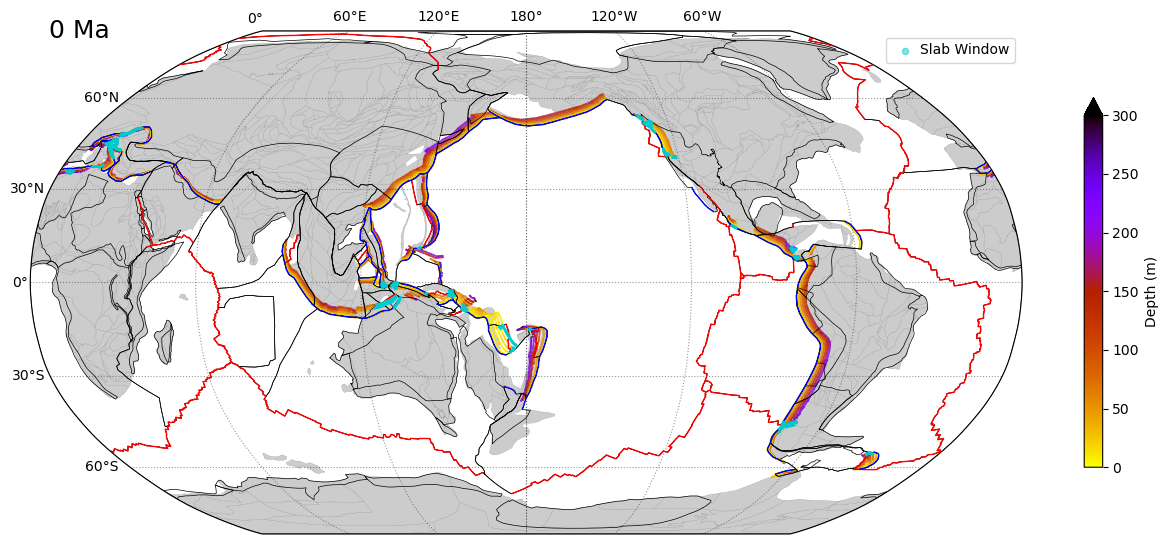

In [10]:
## Test plotting for one timestep
reconstruction_time = 0
plot_slabs(reconstruction_time, save_image=False)

## Create Animation

#### Generate images for each timestep:

In [11]:
## --- Run Normally ---
for reconstruction_time in time_range:
    plot_slabs(reconstruction_time, save_image=True)
    print(f'Saved figure for {reconstruction_time} Ma')

## --- Run in Parallel---
# _ = Parallel(n_jobs=-3, backend='multiprocessing', verbose=1)\
# (delayed(plot_slabs)(reconstruction_time, save_image=True) for reconstruction_time in time_range)

2024-07-26 12:43:17 - py.warnings - WARNING - RuntimeWarning: invalid value encountered in buffer

2024-07-26 12:43:17 - py.warnings - WARNING - RuntimeWarning: invalid value encountered in difference

2024-07-26 12:43:18 - py.warnings - WARNING - RuntimeWarning: invalid value encountered in intersects

2024-07-26 12:43:18 - py.warnings - WARNING - RuntimeWarning: invalid value encountered in intersection

2024-07-26 12:43:18 - py.warnings - WARNING - RuntimeWarning: invalid value encountered in buffer

2024-07-26 12:43:18 - py.warnings - WARNING - RuntimeWarning: invalid value encountered in difference

2024-07-26 12:43:18 - py.warnings - WARNING - RuntimeWarning: invalid value encountered in difference

Saved figure for 45.0 Ma
2024-07-26 12:43:27 - py.warnings - WARNING - RuntimeWarning: invalid value encountered in buffer

2024-07-26 12:43:27 - py.warnings - WARNING - RuntimeWarning: invalid value encountered in difference

2024-07-26 12:43:27 - py.warnings - WARNING - RuntimeWarni

#### Stitch images into video:
Using `moviepy` but can also use `ffmpeg` if preferred.

In [12]:
frame_list = []
for reconstruction_time in time_range:
    fname = fig_dir+f'/slab_windows_{reconstruction_time:02.0f}Ma.png'
    frame_list.append(fname)

In [13]:
mp4 = True
fps = 2.  # number of frames per second in the final animation

clip = mpy.ImageSequenceClip(frame_list, fps=fps)

if mp4:
    clip.write_videofile('Slab_Windows_{:.0f}-{:.0f}Ma.mp4'.format(start_time, end_time))
else:
    clip.write_gif('Slab_Windows_{:.0f}-{:.0f}Ma.gif'.format(start_time, end_time))

Moviepy - Building video Slab_Windows_45-0Ma.mp4.
Moviepy - Writing video Slab_Windows_45-0Ma.mp4



Moviepy - Done !
Moviepy - video ready Slab_Windows_45-0Ma.mp4


#### Optional - Remove output files and individual figures after generating video:

In [ ]:
# if os.path.exists(out_dir):
#     shutil.rmtree(out_dir)

# if os.path.exists(fig_dir):
#     shutil.rmtree(fig_dir)